In [18]:
# Librerías requeridas
import numpy as np
from matplotlib import pyplot as plt
from fuzzy import *

In [80]:
"""
This code defines fuzzy membership functions for error and voltage of a motor.

Functions:
- trapmf(x, params): Trapezoidal membership function.
- gaussmf(x, params): Gaussian membership function.
- trimf(x, params): Triangular membership function.
"""

# Universo de discurso para el error / entrada
e = np.linspace(-10, 10, 100)

# Funciones de pertenencia para el error
ENG = gaussmf(e, [1, -7.5]) #error negativo grande
EC = gaussmf(e, [1, 0.8] ) #error cercano a cero
EPG = gaussmf(e, [1, 8]) #error positivo grande

# Universo de discurso para el voltaje del motor / salida
v = np.linspace(-12, 12, 100) 
 
# Funciones de pertenencia para el voltaje del motor
VNG = gaussmf(v, [1, -7]) #voltaje negativo grande
VC = gaussmf(v, [1, 0]) #voltaje cercano a cero
VPG = gaussmf(v, [1, 7]) #voltaje positivo grande


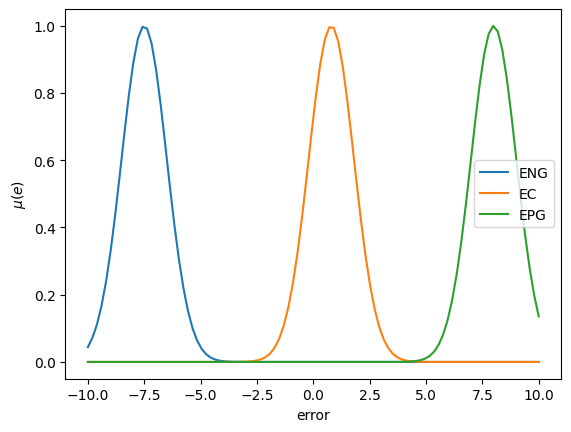

In [81]:
#gráficos para el error
plt.plot(e, ENG, label="ENG")
plt.plot(e, EC, label="EC")
plt.plot(e, EPG, label="EPG")
plt.legend(loc='best')
plt.xlabel('error')
plt.ylabel('$\mu (e)$')
plt.show()

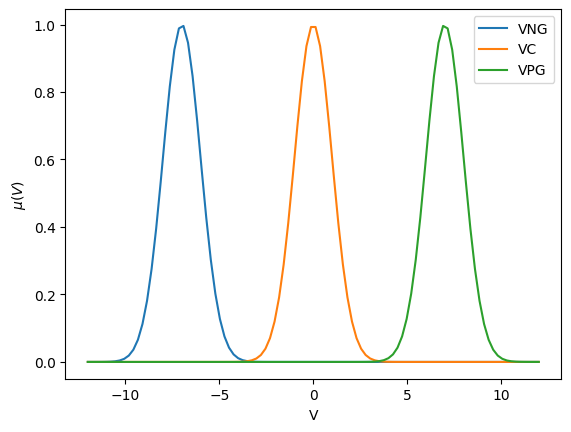

In [82]:
#gráficos para el voltaje
plt.plot(v, VNG, label="VNG")
plt.plot(v, VC, label="VC")
plt.plot(v, VPG, label="VPG")
plt.legend(loc='best')
plt.xlabel('V')
plt.ylabel('$\mu (V)$')
plt.show()

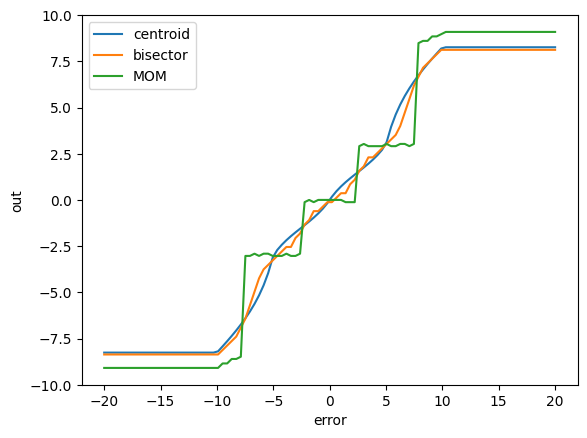

In [84]:
# 1. Definir universo de discurso para entrada y salida
emax = 20
vmax = 12
x = np.linspace(-emax, emax, 100)
y = np.linspace(-vmax, vmax, 100)

# 2. Definir las funciones de membresía para reglas de control
#    Las funciones deben escribirse como una lista:
#    nombre = [funcion, [parametros]]

A1 = [trapmf, [-emax, -emax, -emax/2, -emax/4]]
A2 = [trimf, [-emax/2, -emax/4, 0]]
A3 = [trimf, [-emax/4, 0, emax/4]]
A4 = [trimf, [0, emax/4, emax/2]]
A5 = [trapmf, [emax/4, emax/2, emax, emax]]

B1 = [trapmf, [-vmax, -vmax, -vmax/2, -vmax/4]]
B2 = [trimf, [-vmax/2, -vmax/4, 0]]
B3 = [trimf, [-vmax/4, 0, vmax/4]]
B4 = [trimf, [0, vmax/4, vmax/2]]
B5 = [trapmf, [vmax/4, vmax/2, vmax, vmax]]

A = [A1, A2, A3, A4, A5]
B = [B1, B2, B3, B4, B5]

# 3. Construimos las curvas de control
# Curvas de control para los distintos métodos de defuzzificación:
out_centroid = np.zeros(x.size)
out_bisector = np.zeros(x.size)
out_MOM = np.zeros(x.size)
out_SOM = np.zeros(x.size)
out_LOM = np.zeros(x.size)

for i in range(x.size):
    x0 = float(x[i])
    Bp = fuzz(x0, y, A, B)
    out_centroid[i] = defuzz(y, Bp, 'centroid')
    out_bisector[i] = defuzz(y, Bp, 'bisector')
    out_MOM[i] = defuzz(y, Bp, 'MOM')
    out_SOM[i] = defuzz(y, Bp, 'SOM')
    out_LOM[i] = defuzz(y, Bp, 'LOM')

plt.plot(x, out_centroid, label="centroid")
plt.plot(x, out_bisector, label="bisector")
plt.plot(x, out_MOM, label="MOM")
#plt.plot(x, out_SOM, label="SOM")
#plt.plot(x, out_LOM, label="LOM")
plt.legend()
plt.xlabel('error')
plt.ylabel('out')
plt.show()


In [85]:
# Comenzamos definiendo el modelo de la planta para simular su comportamiento
# La planta corresponde a una función de transferencia de la forma p(s)/v(s) = k/((s+a)*(s+b))
# Para simular requiere como entradas el voltaje del motor (v), una lista de posiciones anteriores (p) y
# el paso de tiempo entre una muestra y la siguiente (dt), que corresponde al inverso de la tasa de muestreo.
# La función retorna como resultado la nueva posición.

def simular(v, p, dt):
    a = 1.5
    b = 25
    k = 2e3
    i = len(p)
    nueva_pos = (dt**2*v*k+((a+b)*dt+2)*p[i-1]-p[i-2])/(a*b*dt**2+(a+b)*dt+1)
    return nueva_pos

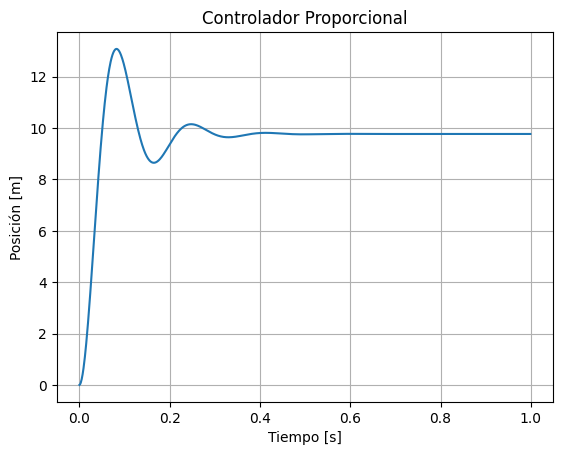

In [86]:
# Controlador Proporcional clasico
kp = 0.8

# Definen parametros de la simulación
t_a = 0
t_f = 1
dt = 0.001

# Definen los valores inciales

pos_a = 0
pos_d = 10
vmotor = 0

t = [t_a]*2
pos = [pos_a]*2

while(True):
    # Obtenemos la posicion actual y el error
    pos_a = simular(vmotor, pos,dt)
    e =  pos_d - pos_a
    # Calcula el voltaje del motor como controlador P
    vmotor = kp*e
    # Guarda los datos para graficar
    t.append(t_a)
    pos.append(pos_a)

    t_a += dt

    if t_a > t_f:
        break

plt.plot(t, pos)
plt.xlabel('Tiempo [s]')
plt.ylabel('Posición [m]')
plt.title('Controlador Proporcional')
plt.grid()
plt.show()



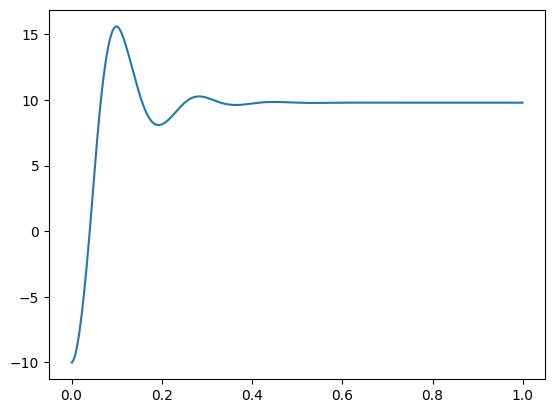

In [87]:
# Y ahora con nuestro controlador difuso

# Definimos los parámetros de nuestro controlador
emax = 20
vmax = 12
x = np.linspace(-emax, emax, 100)
y = np.linspace(-vmax, vmax, 100)

# 2. Definir las funciones de membresía para reglas de control
#    Las funciones deben escribirse como una lista:
#    nombre = [funcion, [parametros]]

A1 = [trapmf, [-emax, -emax, -emax/2, -emax/4]]
A2 = [trimf, [-emax/2, -emax/4, 0]]
A3 = [trimf, [-emax/4, 0, emax/4]]
A4 = [trimf, [0, emax/4, emax/2]]
A5 = [trapmf, [emax/4, emax/2, emax, emax]]

B1 = [trapmf, [-vmax, -vmax, -vmax/2, -vmax/4]]
B2 = [trimf, [-vmax/2, -vmax/4, 0]]
B3 = [trimf, [-vmax/4, 0, vmax/4]]
B4 = [trimf, [0, vmax/4, vmax/2]]
B5 = [trapmf, [vmax/4, vmax/2, vmax, vmax]]

A = [A1, A2, A3, A4, A5]
B = [B1, B2, B3, B4, B5]

# Definimos los parámetros de la simulación ---------------
t_actual = 0   # tiempo inicial en segundos
t_final = 1    # tiempo final en segundos
dt = 0.001     # intervalo de tiempo entre muestras, en segundos

# Definimos los valores iniciales -------------------------
pos_actual = -10.   # posición inicial en centímetros
pos_deseada = 10. # posición deseada en centímetros
vmotor = 0

# Definimos las variables requeridas para la graficar -----
# (repetimos el valor inicial dos veces porque el sistema
#  de segundo orden requiere dos condiciones iniciales)
t = [t_actual]*2
pos = [pos_actual]*2

# Ahora entramos al lazo de control
# calculamos repetidas veces hasta que se cumpla la condición de salida
while (True):
    # obtenemos la posición actual y el error
    pos_actual = simular(vmotor, pos, dt)
    e =  pos_deseada - pos_actual

    # aquí trabaja el controlador ----------
    Bp = fuzz(e, y, A, B)
    out = defuzz(y, Bp, 'centroid')
    vmotor = out
    # --------------------------------------

    # guardamos los datos actuales para graficar
    t.append(t_actual)
    pos.append(pos_actual)

    # actualizamos el vector de tiempo para el siguiente paso
    t_actual += dt

    # y verificamos las condiciones de salida
    if t_actual >= t_final: break

# finalmente graficamos los resultados
plt.plot(t, pos)
plt.show()

<h3>Taller 5 - Ajustando el controlador difuso </h3> <br>
Realice los siguientes ajustes para mejorar la respuesta del controlador difuso. Para efectos de comparación utilice como referencia el controlador proporcional con ganancia kp=0.8 en un cambio de posición entre -10 y 10 centímetros:<br>
1. Definir solo tres valores linguisticos para el error de posición y votaje de motor.<br>
2. Cambiar los parámetros de las funciones de membresía y la forma de las funciones, primero para hacer la zona de error cero más ancha y luego haciéndola más angosta. Observar el efecto que esto tiene sobre la curva de control y en la respuesta del sistema controlado.<br>
3. Probar el efecto de cambiar entre distintos métodos de defussificación, tanto en el tiempo de cálculo de la simulación como también en la respuesta del sistema controlado.<br>
4. A partir de sus observaciones, ajuste las funciones de membresía para conseguir la mejor respuesta posible en el sistema.

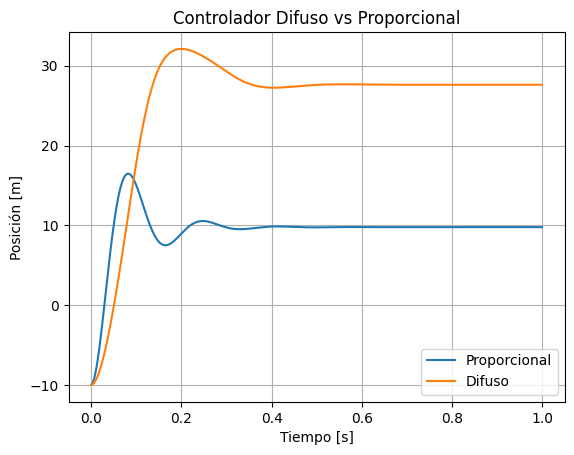

In [88]:
# Para efectos de comparación, se utiliza como referencia el controlador proporcional
# con ganancia kp = 0.8
# en un cambio de posicion de -10 a 10

# Controlador Proporcional
kp = 0.8

# Definen parametros de la simulación
t_a = 0
t_f = 1
dt = 0.001

# Definen los valores inciales

pos_a = -10
pos_d = 10
vmotor = 0

t = [t_a]*2
pos = [pos_a]*2

while(True):
    # Obtenemos la posicion actual y el error
    pos_a = simular(vmotor, pos,dt)
    e =  pos_d - pos_a
    # Calcula el voltaje del motor como controlador P
    vmotor = kp*e
    # Guarda los datos para graficar
    t.append(t_a)
    pos.append(pos_a)

    t_a += dt

    if t_a > t_f:
        break

plt.plot(t, pos)

# Controlador Difuso
emax = 20
vmax = 12
x = np.linspace(-emax, emax, 100)

# Funciones de pertenencia para el error
ENG = gaussmf(x, [-20, -20, -10, -5]) #error negativo grande
EC = gaussmf(x, [1, 0.8] ) #error cercano a cero
EPG = gaussmf(x, [5, 10, 20, 20]) #error positivo grande

# Funciones de pertenencia para el voltaje del motor
v = np.linspace(-12, 12, 100)


VNG = gaussmf(v, [-12, -12, -6, -3]) #voltaje negativo grande
VC = gaussmf(v, [-3, 0, 3]) #voltaje cercano a cero
VPG = gaussmf(v, [3, 6, 12, 12]) #voltaje positivo grande

# Definimos los parámetros de nuestro controlador
emax = 20
vmax = 12
x2 = np.linspace(-emax, emax, 100)
y2 = np.linspace(-vmax, vmax, 100)

# 2. Definir las funciones de membresía para reglas de control
#    Las funciones deben escribirse como una lista:
#    nombre = [funcion, [parametros]]

A1 = [gaussmf, [-emax, -emax, -emax/2, -emax/4]]
A2 = [gaussmf, [-emax/2, -emax/4, 0]]
A3 = [gaussmf, [-emax/4, 0, emax/4]]
A4 = [gaussmf, [0, emax/4, emax/2]]
A5 = [gaussmf, [emax/4, emax/2, emax, emax]]

B1 = [gaussmf, [-vmax, -vmax, -vmax/2, -vmax/4]]
B2 = [gaussmf, [-vmax/2, -vmax/4, 0]]
B3 = [gaussmf, [-vmax/4, 0, vmax/4]]
B4 = [gaussmf, [0, vmax/4, vmax/2]]
B5 = [gaussmf, [vmax/4, vmax/2, vmax, vmax]]


A = [A1, A2, A3, A4, A5]
B = [B1, B2, B3, B4, B5]

# Definimos los parámetros de la simulación ---------------
t_actual = 0   # tiempo inicial en segundos
t_final = 1    # tiempo final en segundos
dt = 0.001     # intervalo de tiempo entre muestras, en segundos

# Definimos los valores iniciales -------------------------
pos_actual = -10.   # posición inicial en centímetros
pos_deseada = 10. # posición deseada en centímetros
vmotor = 0

# Definimos las variables requeridas para la graficar -----
# (repetimos el valor inicial dos veces porque el sistema
#  de segundo orden requiere dos condiciones iniciales)

t = [t_actual]*2
pos = [pos_actual]*2

# Ahora entramos al lazo de control
# calculamos repetidas veces hasta que se cumpla la condición de salida

while (True):
    # obtenemos la posición actual y el error
    pos_actual = simular(vmotor, pos, dt)
    e =  pos_deseada - pos_actual

    # aquí trabaja el controlador ----------
    Bp = fuzz(e, y2, A, B)
    out = defuzz(y2, Bp, 'centroid')
    vmotor = out
    # --------------------------------------

    # guardamos los datos actuales para graficar
    t.append(t_actual)
    pos.append(pos_actual)

    # actualizamos el vector de tiempo para el siguiente paso
    t_actual += dt

    # y verificamos las condiciones de salida
    if t_actual >= t_final: break

# finalmente graficamos los resultados
plt.plot(t, pos)
plt.xlabel('Tiempo [s]')
plt.ylabel('Posición [m]')
plt.title('Controlador Difuso vs Proporcional')
plt.legend(['Proporcional', 'Difuso'])
plt.grid()
plt.show()

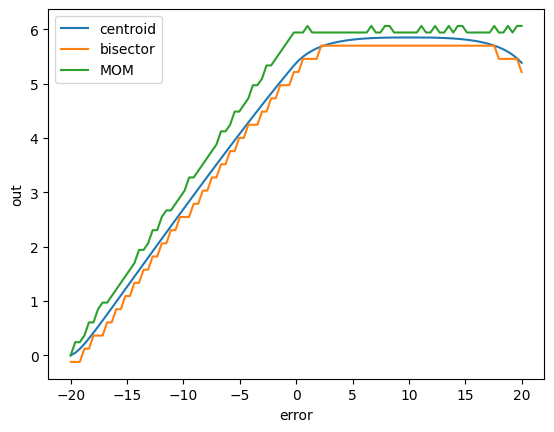

In [89]:
#Probar el efecto de cambiar los distintos metodos de desfusificación( centroid, bisector y MOM), para el tiempo de calculo
#y la estabilidad del sistema
out_centroid = np.zeros(x2.size)
out_bisector = np.zeros(x2.size)
out_MOM = np.zeros(x2.size)


for i in range(x2.size):
    x0 = float(x2[i])
    Bp = fuzz(x0, y2, A, B)
    out_centroid[i] = defuzz(y2, Bp, 'centroid')
    out_bisector[i] = defuzz(y2, Bp, 'bisector')
    out_MOM[i] = defuzz(y2, Bp, 'MOM')
    out_SOM[i] = defuzz(y2, Bp, 'SOM')
    out_LOM[i] = defuzz(y2, Bp, 'LOM')

plt.plot(x2, out_centroid, label="centroid")
plt.plot(x2, out_bisector, label="bisector")
plt.plot(x2, out_MOM, label="MOM")

plt.legend()
plt.xlabel('error')
plt.ylabel('out')
plt.show()
